In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from backend.signal_processing import (
    sigpro_utility,
    signal_transform,
)

In [2]:
# -------------------------------- Loading Step --------------------------------
input_nd2 = '../../data/raw_nd2/3-SR_1_5_4h_Pre-C_1h_1mMIPTG_After2h_MCM1.nd2'
input_frames = sigpro_utility.parse_nd2_file(input_nd2)

/mnt/shared/code/damp_lab/beholder/.venv/lib/python3.8/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (194047.3 ms) doesn't match the set interval (300000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)
/mnt/shared/code/damp_lab/beholder/.venv/lib/python3.8/site-packages/nd2reader/parser.py:292: UserWarning: ND2 file contains gap frames which are represented by np.nan-filled arrays; to convert to zeros use e.g. np.nan_to_num(array)
  warnings.warn('ND2 file contains gap frames which are represented by np.nan-filled arrays; to convert to zeros use e.g. np.nan_to_num(array)')


In [3]:
# --------------------------- Utility Functionality ----------------------------
def purge_blank_frames(frames):
    out_list = []
    for f_index in range(0, len(frames), 3):
        grey_frame = frames[f_index]
        red_frame = frames[f_index + 1]
        green_frame = frames[f_index + 2]
        if not any(
                map(
                    sigpro_utility.empty_frame_check,
                    [grey_frame, red_frame, green_frame]
                    )
                ):
                    out_list.append(grey_frame)
                    out_list.append(red_frame)
                    out_list.append(green_frame)
        else:
            continue
    return out_list

def data_filter(frames, bin_num: int = 20, threshold_edge: int = 1):
        out_frames = []
        for f in frames:
            _grey_frame, _red_frame, _green_frame = f
            r_hist, r_bins = np.histogram(_red_frame, bins=bin_num)
            _red_frame = _red_frame[
                np.where(_red_frame >= r_bins[threshold_edge])
            ]
            # ---
            g_hist, g_bins = np.histogram(_green_frame, bins=bin_num)
            _green_frame = _green_frame[
                np.where(_green_frame >= g_bins[threshold_edge])
            ]
            out_frames.append([_grey_frame, _red_frame, _green_frame])
        return out_frames


In [4]:

def fetch_and_colorize(frames):
    out_list = []
    for f in frames:
        _grey_frame, _red_frame, _green_frame = f
        _grey_frame = signal_transform.downsample_image(_grey_frame)
        _red_frame = signal_transform.downsample_image(_red_frame)
        _green_frame = signal_transform.downsample_image(_green_frame)
        _grey_frame = signal_transform.colorize_frame(_grey_frame, 'grey')
        _red_frame = signal_transform.colorize_frame(_red_frame, 'red')
        _green_frame = signal_transform.colorize_frame(_green_frame, 'green')
        _green_frame = signal_transform.apply_brightness_contrast(_green_frame)
        _red_frame = signal_transform.apply_brightness_contrast(_red_frame)
        # Below is Aesthetic, but might be wrong.
        _red_frame = cv2.addWeighted(_red_frame, 3, _red_frame, 0, 0)
        _green_frame = cv2.addWeighted(_green_frame, 1, _green_frame, 0, 0)
        out_frame = signal_transform.combine_frame(
            _grey_frame,
            _red_frame,
            beta=0.1,
        )
        out_frame = signal_transform.combine_frame(
            out_frame,
            _green_frame,
            beta=0.1,
        )
        out_frame = cv2.addWeighted(out_frame, 3, out_frame, 0, 10)
        out_list.append(out_frame)
    return out_list

In [5]:

def fetch_and_histogram(frames):
    out_list = []
    frames = data_filter(frames)
    for f in frames:
        _, _red_frame, _green_frame = f
        r_hist, r_bins = np.histogram(_red_frame, bins=20)
        r_width = 0.8 * (r_bins[1] - r_bins[0])
        r_center = (r_bins[:-1] + r_bins[1:]) / 2
        # ---
        g_hist, g_bins = np.histogram(_green_frame, bins=20)
        g_width = 0.8 * (g_bins[1] - g_bins[0])
        g_center = (g_bins[:-1] + g_bins[1:]) / 2
        out_list.append([
            [r_hist, r_bins, r_width, r_center],
            [g_hist, g_bins, g_width, g_center]
        ]
        )
    return out_list

In [6]:
def fetch_and_compare(frames):
    red_list = [[], [], []]
    green_list = [[], [], []]
    green_cov_l = []
    red_cov_l = []
    frames = data_filter(frames)
    for f in frames:
        _, _red_frame, _green_frame = f
        green_mean = np.mean(_green_frame)
        green_cov = np.std(_green_frame)/np.mean(_green_frame)
        green_cov_l.append(green_cov)
        green_standard_error = np.std(_green_frame)/(np.sqrt(_green_frame.shape[0] * _green_frame.shape[0]))
        red_standard_error = np.std(_red_frame)/(np.sqrt(_red_frame.shape[0] * _red_frame.shape[0]))
        green_neg = green_mean - green_standard_error if green_mean - green_standard_error > 0 else 0
        green_pos = green_mean + green_standard_error
        # ---
        red_mean = np.mean(_red_frame)
        red_cov = np.std(_red_frame)/np.mean(_red_frame)
        red_cov_l.append(red_cov)
        red_neg = red_mean - red_standard_error if red_mean - red_standard_error > 0 else 0
        red_pos = red_mean + red_standard_error
        red_list[0].append(red_mean)
        red_list[1].append(red_neg)
        red_list[2].append(red_pos)
        green_list[0].append(green_mean)
        green_list[1].append(green_neg)
        green_list[2].append(green_pos)
    return [red_list, green_list]

In [88]:
def generate_frames_plot(frame_indices, frame_labels, plot_axes):
    colored_frames = fetch_and_colorize(frame_indices)
    f_iter = zip(colored_frames, frame_labels, plot_axes)
    for frame, label, axis in f_iter:
        axis.imshow(frame, interpolation='nearest')
        axis.tick_params(
            bottom=False,
            labelbottom=False,
            left=False,
            labelleft=False,
        )
        # axis.set_xticklabels([])
        # axis.set_yticklabels([])
        # axis.set_aspect('equal')


In [14]:
def generate_histogram_plot(frame_indices, frame_labels, plot_axes):
    hist_list = fetch_and_histogram(frame_indices)
    h_iter = zip(hist_list, frame_labels, plot_axes)
    for hist, label, axis in h_iter:
        red_hist_stats = hist[0]
        green_hist_stats = hist[1]
        r_hist, r_bins, r_width, r_center = red_hist_stats
        g_hist, g_bins, g_width, g_center = green_hist_stats
        axis.bar(
            range(len(r_bins)-1),
            r_hist,
            width=1,
            color='red',
            alpha=1,
        )
        axis.bar(
            range(len(g_bins)-1),
            g_hist,
            width=1,
            alpha=1,
            color='green',
        )
        axis.set_title(label)
    for axis in plot_axes[1:]:
        axis.tick_params(
            bottom=True,
            labelbottom=True,
            left=False,
            labelleft=False,
        )
    plot_axes[0].tick_params(
        bottom=True,
        labelbottom=True,
        left=True,
        labelleft=True,
    )
    plot_axes[0].set_ylabel('Frequency')
    plot_axes[0].set_yticklabels([
        '0',
        '1/4',
        '1/2',
        '3/4',
        '1',
        ]
    )
    plot_axes[2].set_xlabel('Intensity, (a.u. x10^4)')

In [138]:
def generate_ts_plot(frames, time_indicies, axis):
    red_list, green_list = fetch_and_compare(frames)
    t_iter = red_list[0], green_list[0]
    axis.set_prop_cycle(color=['red', 'green'])
    red_neg, red_pos = red_list[1], red_list[2]
    green_neg, green_pos = green_list[1], green_list[2]
    axis.plot(time_indicies, t_iter[0])
    axis.plot(time_indicies, t_iter[1])
    axis.fill_between(
        time_indicies,
        green_neg,
        green_pos,
        alpha=.2,
        color='lime',
    )
    axis.fill_between(
            time_indicies,
            red_neg,
            red_pos,
            alpha=.8,
            color='pink',
        )
    # axis.tick_params(
    #     bottom=True,
    #     labelbottom=True,
    #     left=True,
    #     labelleft=True,
    # )
    axis.set_ylabel('Intensity, (a.u. x10^4)')
    axis.set_xlabel('Time (h)')
    axis.set_xlim(570, 600)
    # axis.set_yticklabels([
    #     '1.25',
    #     '1.50',
    #     '1.75',
    #     '2.0',
    #     '2.25'
    #     ]
    # )
    axis.set_xticklabels(
        [
            ''
            '00:00',
            '',
            '',
            '06:30',
            '',
            '',
            '13:00',
        ])

In [139]:

def generate_master_plot(
        frames,
        time_indicies,
        title,
        time_series_titles,
):
    fig = plt.figure(figsize=(13, 6))
    grid = plt.GridSpec(3, 5, hspace=0.4, wspace=0.02)
    plt.title(f'{title}', fontsize=16, y=1.10)
    for ax in fig.get_axes():
        ax.tick_params(
            bottom=False,
            labelbottom=False,
            left=False,
            labelleft=False,
        )
    # These define the individual frames being shown.
    frame_1 = fig.add_subplot(grid[0, 0])
    frame_2 = fig.add_subplot(grid[0, 1])
    frame_3 = fig.add_subplot(grid[0, 2])
    frame_4 = fig.add_subplot(grid[0, 3])
    frame_5 = fig.add_subplot(grid[0, 4])
    ax_frame_list = [frame_1, frame_2, frame_3, frame_4, frame_5]
    # Histogram Specification
    hist_1 = fig.add_subplot(grid[1, 0])
    hist_2 = fig.add_subplot(grid[1, 1])
    hist_3 = fig.add_subplot(grid[1, 2])
    hist_4 = fig.add_subplot(grid[1, 3])
    hist_5 = fig.add_subplot(grid[1, 4])
    ax_hist_list = [hist_1, hist_2, hist_3, hist_4, hist_5]
    # Timeseries Specification
    ts_1 = fig.add_subplot(grid[2, :])
    # frame_1.tick_params(
    #     bottom=False,
    #     labelbottom=False,
    #     left=False,
    #     labelleft=False,
    # )
    generate_frames_plot(
            frames,
            time_series_titles,
            ax_frame_list,
        )
    generate_histogram_plot(
            frames,
            time_series_titles,
            ax_hist_list,
        )
    generate_ts_plot(frames, time_indicies, ts_1)
    plt.savefig('test.jpg', dpi=300)
    plt.show()

<ipython-input-14-0bdd75e1a4b9>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot_axes[0].set_yticklabels([
<ipython-input-138-c8b3ac3c7d98>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(


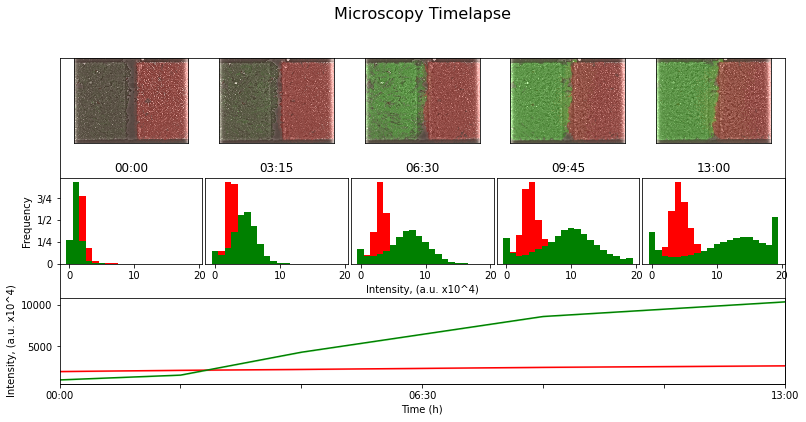

In [140]:
time_series_points = [570, 575, 580, 590, 600]
# time_series_points = [450, 550, 650, 750, 840]
time_points = ['00:00', '03:15', '06:30', '09:45', '13:00']
input_frames = purge_blank_frames(input_frames)
active_list = []
for time_point in time_series_points:
    _, red, green = input_frames[time_point]

for time_point in time_series_points:
    active_list.append(input_frames[time_point])
generate_master_plot(
    active_list,
    time_series_points,
    'Microscopy Timelapse',
    time_points,
)

In [137]:
import pandas as pd
time_points = ['00:00', '03:15', '06:30', '09:45', '13:00']
for time_point, frame_group in zip(time_points, active_list):
    gy_frame, rd_frame, gn_frame = frame_group
    df = pd.DataFrame(
        {
        'grey': np.ravel(gy_frame),
        'red': np.ravel(rd_frame),
        'green': np.ravel(gn_frame),
        }
    )
    df.to_csv(f'{time_point}.csv')

